In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/10884668/two-sample-kolmogorov-smirnov-test-in-python-scipy
from scipy.stats import ks_2samp

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from utils import *

In [5]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

# Intro

Ingesting some base data

In [6]:
ibge_municipio = pd.read_parquet('../data/ibge_municipio_pib.parquet')

ibge_municipio['municipioCodigo'] = ibge_municipio['municipioCodigo'].astype(str)
ibge_municipio['municipioCodigo6d'] = ibge_municipio['municipioCodigo'].str.slice(0, 6)

ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipio'].apply(replace_accents)
ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipioNorm'].apply(lambda x: re.sub(r"[^a-zA-Z\d\_]+", " ", x))
ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipioNorm'].str.upper()

ibge_municipio = ibge_municipio[['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d']]
ibge_municipio = ibge_municipio.drop_duplicates()

inspect(ibge_municipio);

shape: (5570, 7)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,ALTA FLORESTA D OESTE,1100015,110001
1,RO,11,Rondônia,Ariquemes,ARIQUEMES,1100023,110002
2,RO,11,Rondônia,Cabixi,CABIXI,1100031,110003
3,RO,11,Rondônia,Cacoal,CACOAL,1100049,110004
4,RO,11,Rondônia,Cerejeiras,CEREJEIRAS,1100056,110005


In [7]:
rais_caged_cnpj = inspect(
    pd.read_parquet('../data/rais_caged_cnpj.parquet')
    .merge(ibge_municipio.rename(columns={'uf': 'enderecoUf', 'nomeMunicipioNorm': 'enderecoMunicipio'}), on=['enderecoUf', 'enderecoMunicipio'])
)

shape: (22832693, 10)
columns: ['cnpj', 'ano', 'funcionarios', 'enderecoUf', 'enderecoMunicipio', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d']


,cnpj,ano,funcionarios,enderecoUf,enderecoMunicipio,ufCodigo,nomeUf,nomeMunicipio,municipioCodigo,municipioCodigo6d
0,00000000066370,2010,6,SP,SAO PAULO,35,São Paulo,São Paulo,3550308,355030
1,00000000066370,2011,7,SP,SAO PAULO,35,São Paulo,São Paulo,3550308,355030
2,00000000066370,2012,8,SP,SAO PAULO,35,São Paulo,São Paulo,3550308,355030
3,00000000066370,2013,9,SP,SAO PAULO,35,São Paulo,São Paulo,3550308,355030
4,00000000066370,2014,11,SP,SAO PAULO,35,São Paulo,São Paulo,3550308,355030


In [8]:
ibge_municipio_pib = pd.read_parquet('../data/ibge_municipio_pib.parquet')
ibge_municipio_pib['municipioCodigo'] = ibge_municipio_pib['municipioCodigo'].astype(str)
ibge_municipio_pib['municipioCodigo6d'] = ibge_municipio_pib['municipioCodigo'].str.slice(0, 6)

inspect(ibge_municipio_pib);

shape: (5570, 18)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'ano', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,municipioCodigo,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,ano,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,1100015,169623,27805,117717,154926,470072,28793,498864,19612,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária",Demais serviços\r,2017,110001
1,RO,11,Rondônia,Ariquemes,1100023,165217,330319,933935,634591,2064062,232012,2296074,21390,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,2017,110002
2,RO,11,Rondônia,Cabixi,1100031,63022,4797,22431,43150,133399,5494,138894,22316,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária","Agricultura, inclusive apoio à agricultura e a...",2017,110003
3,RO,11,Rondônia,Cacoal,1100049,255060,224595,908665,521368,1909689,217835,2127523,24038,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,2017,110004
4,RO,11,Rondônia,Cerejeiras,1100056,61940,22170,192882,107819,384811,63713,448524,25010,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,2017,110005


In [9]:
ibge_municipio_populacao_estimada = pd.read_parquet('../data/ibge_municipio_populacao_estimada.parquet')

ibge_municipio_populacao_estimada['municipioCodigo'] = ibge_municipio_populacao_estimada['municipioCodigo'].astype(str)
ibge_municipio_populacao_estimada['municipioCodigo'] = ibge_municipio_populacao_estimada['municipioCodigo'].str.pad(5, fillchar='0')
ibge_municipio_populacao_estimada['municipioCodigo'] = (
    ibge_municipio_populacao_estimada['ufCodigo'].astype(str) + ibge_municipio_populacao_estimada['municipioCodigo']
)

ibge_municipio_populacao_estimada['municipioCodigo6d'] = ibge_municipio_populacao_estimada['municipioCodigo'].str.slice(0, 6)

# categorizacao da populacao estimada em faixas
max_pop = int(ibge_municipio_populacao_estimada['populacaoEstimada'].max())
pop_bins = [i * 10000 for i in [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]] + [max_pop]
pop_labels = [
    ('{}:{}'.format(
        str(int(pop_bins[(i)])),
        str(int(pop_bins[(i+1)])) if (i + 1) < len(pop_bins) else str(max_pop)
    ))
    for i, n in enumerate(pop_bins[:-1])
]

ibge_municipio_populacao_estimada['faixaPopulacaoEstimada'] = pd.cut(
    ibge_municipio_populacao_estimada['populacaoEstimada'],
    bins=pop_bins,
    labels=pop_labels
)

inspect(ibge_municipio_populacao_estimada);

shape: (5570, 8)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'ano', 'municipioCodigo6d', 'faixaPopulacaoEstimada']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,ano,municipioCodigo6d,faixaPopulacaoEstimada
0,RO,11,Alta Floresta D'Oeste,1100015,22945.000,2020,110001,20000:30000
1,RO,11,Ariquemes,1100023,107863.000,2020,110002,80000:130000
2,RO,11,Cabixi,1100031,5312.000,2020,110003,0:10000
3,RO,11,Cacoal,1100049,85359.000,2020,110004,80000:130000
4,RO,11,Cerejeiras,1100056,16323.000,2020,110005,10000:20000


In [10]:
ibge_setor_censo_basico = pd.read_parquet('../data/ibge_setor_censo_basico.parquet')
ibge_setor_censo_basico['codigoMunicipio'] = ibge_setor_censo_basico['codigoMunicipio'].astype(str)
ibge_setor_censo_basico['codigoMunicipio6d'] = ibge_setor_censo_basico['codigoMunicipio'].str.slice(0, 6)
ibge_setor_censo_basico = ibge_setor_censo_basico.drop(columns=['nomeUf', 'nomeMunicipio'])
inspect(ibge_setor_censo_basico);

shape: (310082, 36)
columns: ['codigoSetor', 'codigoGrandeRegiao', 'nomeGrandeRegiao', 'codigoUf', 'codigoMesoRegiao', 'nomeMesoRegiao', 'codigoMicroRegiao', 'nomeMicroRegiao', 'codigoRegiaoMetropolitana', 'nomeRegiaoMetropolitana', 'codigoMunicipio', 'codigoDistrito', 'nomeDistrito', 'codigoSubdistrito', 'nomeSubdistrito', 'codigoBairro', 'nomeBairro', 'situacaoSetor', 'tipoSetor', 'domicilios', 'moradores', 'mediaMoradoresDomicilios', 'varianciaMoradoresDomicilios', 'rendaMediaMensalMoradores', 'varianciaRendaMediaMensalMoradores', 'rendaMediaMensalMoradoresAssalariados', 'varianciaRendaMediaMensalMoradoresAssalariados', 'rendaMediaMensalMoradoresAcima10Anos', 'varianciaRendaMediaMensalMoradoresAcima10Anos', 'rendaMediaMensalMoradoresAcima10AnosAssalariados', 'varianciaRendaMediaMensalMoradoresAcima10AnosAssalariados', 'urbano', 'rural', 'metropolitano', 'siglaUf', 'codigoMunicipio6d']


,codigoSetor,codigoGrandeRegiao,nomeGrandeRegiao,codigoUf,codigoMesoRegiao,nomeMesoRegiao,codigoMicroRegiao,nomeMicroRegiao,codigoRegiaoMetropolitana,nomeRegiaoMetropolitana,codigoMunicipio,codigoDistrito,nomeDistrito,codigoSubdistrito,nomeSubdistrito,codigoBairro,nomeBairro,situacaoSetor,tipoSetor,domicilios,moradores,mediaMoradoresDomicilios,varianciaMoradoresDomicilios,rendaMediaMensalMoradores,varianciaRendaMediaMensalMoradores,rendaMediaMensalMoradoresAssalariados,varianciaRendaMediaMensalMoradoresAssalariados,rendaMediaMensalMoradoresAcima10Anos,varianciaRendaMediaMensalMoradoresAcima10Anos,rendaMediaMensalMoradoresAcima10AnosAssalariados,varianciaRendaMediaMensalMoradoresAcima10AnosAssalariados,urbano,rural,metropolitano,siglaUf,codigoMunicipio6d
0,172210705000007,1,Regio Norte,17,1701,Ocidental do Tocantins,17002,Araguana,0,Municpios no pertencentes a estrutura de RM,1722107,172210705,XAMBIO,17221070500,XAMBIO,1722107000,XAMBIO (todos os setores),1,0,200.000,696.000,3.480,2.880,1428.280,7479003.290,1660.780,8315228.320,799.950,4353803.010,1369.360,6679874.820,True,False,True,TO,172210
1,172210705000012,1,Regio Norte,17,1701,Ocidental do Tocantins,17002,Araguana,0,Municpios no pertencentes a estrutura de RM,1722107,172210705,XAMBIO,17221070500,XAMBIO,1722107000,XAMBIO (todos os setores),5,0,51.000,186.000,3.650,3.230,436.590,48399.250,494.800,25541.350,230.580,67880.830,430.820,40199.910,False,True,True,TO,172210
2,172210705000017,1,Regio Norte,17,1701,Ocidental do Tocantins,17002,Araguana,0,Municpios no pertencentes a estrutura de RM,1722107,172210705,XAMBIO,17221070500,XAMBIO,1722107000,XAMBIO (todos os setores),8,8,63.000,222.000,3.520,3.190,338.250,201259.810,519.760,215257.440,186.770,126269.490,470.750,185390.270,False,True,True,TO,172210
3,130260305100011,1,Regio Norte,13,1303,Centro Amazonense,13007,Manaus,01,RM Manaus,1302603,130260305,MANAUS,13026030510,QUINTA R.A.,1302603030,Crespo,1,0,239.000,858.000,3.590,4.580,596.630,409818.280,792.190,389111.090,477.390,369008.550,785.700,365076.790,True,False,True,AM,130260
4,130260305120424,1,Regio Norte,13,1303,Centro Amazonense,13007,Manaus,01,RM Manaus,1302603,130260305,MANAUS,13026030512,STIMA R.A.,1302603058,Novo Aleixo,1,0,213.000,866.000,4.070,4.100,782.960,906966.390,947.560,941864.900,409.390,459029.440,799.000,584943.550,True,False,True,AM,130260


In [11]:
# https://github.com/datasets-br/cbo
# https://www.hardware.com.br/comunidade/attachments/cbo-xlsx.37816/
cbos = pd.read_csv('../data/cbo.csv')

cbos.head()

,codigoCbo,ocupacaoCbo
0,848505,ABATEDOR
1,764305,ACABADOR DE CALCADOS
2,766305,ACABADOR DE EMBALAGENS (FLEXIVEIS E CARTOTECNI...
3,716105,ACABADOR DE SUPERFICIES DE CONCRETO
4,848510,ACOUGUEIRO


## Target Population

Ingest dataset to define target population

In [12]:
sim_pf_homcidios = pd.read_csv(
    '../data/1. SIM (Homicidios)/DadosHomicidios_2013-18_SIM.csv',
    dtype={'dtnasc': str},
    low_memory=False
)

sim_pf_homcidios.columns = sim_pf_homcidios.columns.str.lower()

sim_pf_homcidios['codmunocor'] = sim_pf_homcidios['codmunocor'].astype(str)

# sim_pf_homcidios['dtnasc'] = sim_pf_homcidios['dtnasc'].astype(int).astype(str).pad(8, fillchar='0')

# Data em que occoreu o óbito
sim_pf_homcidios['dtobito'] = pd.to_datetime((sim_pf_homcidios['dtobito'].astype(int).astype(str)).str.pad(8, fillchar='0'), format='%d%m%Y')

# Horário do óbito.
sim_pf_homcidios['horaobito'] = sim_pf_homcidios['horaobito'].fillna(-9999)
sim_pf_homcidios['horaobito'] = (sim_pf_homcidios['horaobito'].astype(int).astype(str)).str.pad(4, fillchar='0')
sim_pf_homcidios['horaobito'] = (sim_pf_homcidios['horaobito'].str.slice(0, 2).astype(int) * 60 + sim_pf_homcidios['horaobito'].str.slice(2, 4).astype(int))/float(60)
sim_pf_homcidios['horaobito'] = np.where(sim_pf_homcidios['horaobito'] < 0, np.nan, sim_pf_homcidios['horaobito'])

# Tipo de trabalho que o falecido desenvolveu na maior parte de sua vida produtiva (CBO 2002).
# sim_pf_homcidios['ocup'] = ocup
sim_pf_homcidios['ocup'] = sim_pf_homcidios['ocup'].fillna(-1)
sim_pf_homcidios['ocup'] = sim_pf_homcidios['ocup'].astype(int)

# Tipo de morte violenta ou circunstâncias em que se deu a morte não  natural
circobito_map = {1: "acidente", 2: "suicídio", 3: "homicídio", 4: "outros", 9: "ignorado"}

# Sexo do falecido
sexo_map = {0: "ignorado", 1: "masculino", 2: "feminino"}

# Cor informada pelo responsável pelas informações do falecido.
racacor_map = {1: "Branca", 2: "Preta", 3: "Amarela", 4: "Parda", 5: "Indígena"}

# Local de ocorrência do óbito.
lococor_map = {
    1: "hospital", 2: "outros estabelecimentos de saúde", 3: "domicílio",
    4: "via pública", 5: "outros", 6: "aldeia indígena", 9: "ignorado"
}

# Se refere ao atendimento médico continuado que o paciente recebeu,  ou não , durante a enfermidade que ocasionou o óbito.
assistmed_map = {1: "sim", 2: "não", 9: "ignorado"}

# col maps
sim_pf_homcidios = sim_pf_homcidios.replace({
    "circobito": circobito_map,
    "sexo": sexo_map,
    "racacor": racacor_map,
    "lococor": lococor_map,
    "assistmed": assistmed_map,
})

# combinando dados
sim_pf_homcidios = (
    sim_pf_homcidios
    .merge(ibge_municipio.rename(columns={'municipioCodigo6d': 'codmunocor'}), on='codmunocor')
    .merge(cbos.rename(columns={'codigoCbo': 'ocup'}), on='ocup', how='left')
)

# extraindo outras caracteristicas a partir da ocupacao
sim_pf_homcidios['ocupacaoCbo'] = sim_pf_homcidios['ocupacaoCbo'].fillna('IGNORADO')
sim_pf_homcidios['semOcupacao'] = sim_pf_homcidios['ocup'].isin([-1, 999991, 999994, 998999])

# O primeiro, de 1 dígito, indica a unidade da idade (se 1 = minuto, se 2 = hora, se 3 = mês, se 4 = ano,  se = 5 idade maior que 100 anos)
# Anos - subcampo varia de 00 a 99; - 9 - ignorado)
# Homicídios de Jovens (15 a 29 anos)
sim_pf_homcidios = sim_pf_homcidios[(sim_pf_homcidios['idade'] >= 400) & (sim_pf_homcidios['idade'] < 500)]
sim_pf_homcidios['idade'] = (sim_pf_homcidios['idade'].astype(str).str.slice(1, 3)).astype(int)
sim_pf_homcidios = sim_pf_homcidios[(sim_pf_homcidios['idade'] >= 15) & (sim_pf_homcidios['idade'] < 30)]

# considerando apenas homicídios
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios['circobito'] == 'homicídio']

# removendo variaveis com preenchimento muito baixo (<20%)
sim_pf_homcidios_fill_rate = mg.fill_rate(sim_pf_homcidios)
sim_pf_homcidios_low_fill_rate_cols = sim_pf_homcidios_fill_rate[sim_pf_homcidios_fill_rate['Fill (%)'] < 20]['Variable'].tolist()
sim_pf_homcidios_cols = [i for i in sim_pf_homcidios.columns.tolist() if i not in sim_pf_homcidios_low_fill_rate_cols]
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios_cols]

# numerolote, contador, linhac

print('low_fill_rate_cols: ', sim_pf_homcidios_low_fill_rate_cols)

inspect(sim_pf_homcidios);


# MUNIOCOR
# UFINFORM
# CODMUNOCOR
# CODMUNOCOR
# CIRCOBITO
# dtobito
# IDADE
# sexo
# racacor
# dtnasc
# ocup
# LOCOCOR OK
# FILHMORT # nao tem
# FILHVIVOS

low_fill_rate_cols:  ['peso', 'escmae', 'escmae2010', 'seriescmae', 'ocupmae', 'qtdfilvivo', 'qtdfilmort', 'idademae', 'gravidez', 'gestacao', 'parto', 'obitoparto', 'dtcadinf', 'cb_pre', 'dtconcaso', 'semagestac', 'nudiasinf', 'morteparto', 'escmaeagr1', 'estabdescr', 'altcausa', 'causamat', 'acidtrab', 'exame', 'cirurgia', 'tpresginfo', 'nudiasobin', 'fontes', 'dtregcart', 'numregcart', 'codmuncart', 'nudiasobco', 'tpnivelinv', 'tpmorteoco', 'obitopuerp', 'obitograv', 'dtconinv', 'dtcadinv', 'tpobitocor', 'linhaii', 'dtrecorig', 'fontesinf', 'linhad']
shape: (182444, 56)
columns: ['contador', 'origem', 'tipobito', 'dtobito', 'horaobito', 'natural', 'dtnasc', 'idade', 'sexo', 'racacor', 'estciv', 'esc', 'esc2010', 'seriescfal', 'ocup', 'codmunres', 'lococor', 'codestab', 'codmunocor', 'assistmed', 'necropsia', 'linhaa', 'linhab', 'linhac', 'causabas', 'comunsvoim', 'dtatestado', 'circobito', 'fonte', 'tppos', 'dtinvestig', 'causabas_o', 'dtcadastro', 'atestante', 'fonteinv', 'dtrecebi

,contador,origem,tipobito,dtobito,horaobito,natural,dtnasc,idade,sexo,racacor,estciv,esc,esc2010,seriescfal,ocup,codmunres,lococor,codestab,codmunocor,assistmed,necropsia,linhaa,linhab,linhac,causabas,comunsvoim,dtatestado,circobito,fonte,tppos,dtinvestig,causabas_o,dtcadastro,atestante,fonteinv,dtrecebim,difdata,stdoepidem,stdonova,codmunnatu,numerolote,stcodifica,codificado,versaosist,versaoscb,atestado,dtrecoriga,escfalagr1,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,ocupacaoCbo,semOcupacao
0,49,1,2,2013-06-30,5.000,NaN,9101987.000,25,masculino,Branca,5.000,3.000,2.000,NaN,-1,120035,hospital,2001594.000,120035,NaN,NaN,*X990,NaN,NaN,X990,NaN,NaN,homicídio,3.000,NaN,NaN,X990,14082013.000,NaN,NaN,31012014.000,45.000,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AC,12,Acre,Marechal Thaumaturgo,MARECHAL THAUMATURGO,1200351,IGNORADO,True
2,1077,1,2,2015-10-22,17.000,812.000,4101987.000,28,feminino,Branca,2.000,2.000,1.000,NaN,999992,120035,domicílio,NaN,120035,não,2.000,*X940,NaN,NaN,X940,NaN,22102015.000,homicídio,1.000,N,NaN,X940,30102015.000,5.000,NaN,30102015.000,8.000,0.000,1.000,120035.000,20150014.000,S,S,3.2.00,3.200,X940,30102015.000,10.000,AC,12,Acre,Marechal Thaumaturgo,MARECHAL THAUMATURGO,1200351,DONA DE CASA,False
4,3385,1,2,2016-11-29,2.000,812.000,30081987.000,29,masculino,Branca,1.000,4.000,3.000,3.000,-1,120035,hospital,2001594.000,120035,sim,2.000,*R571,*X994,NaN,X994,NaN,29112016.000,homicídio,3.000,N,NaN,X994,16122016.000,5.000,NaN,16122016.000,17.000,0.000,1.000,120035.000,20160019.000,S,S,3.2.00,3.200,R571/X994,16122016.000,6.000,AC,12,Acre,Marechal Thaumaturgo,MARECHAL THAUMATURGO,1200351,IGNORADO,True
5,267,1,2,2013-04-28,17.083,NaN,29011991.000,22,feminino,Parda,5.000,3.000,1.000,4.000,999992,120030,outros,NaN,120030,não,2.000,*Y004,*S061,NaN,Y004,NaN,28042013.000,homicídio,2.000,N,NaN,Y004,23082013.000,5.000,NaN,30082013.000,124.000,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AC,12,Acre,Feijó,FEIJO,1200302,DONA DE CASA,False
11,1867,1,2,2013-11-01,23.000,NaN,13081993.000,20,masculino,Parda,5.000,1.000,0.000,NaN,999992,120030,outros,NaN,120030,não,2.000,*S211,*S311,*X998,X998,NaN,2112013.000,homicídio,3.000,N,NaN,X998,4112013.000,5.000,NaN,14112013.000,13.000,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AC,12,Acre,Feijó,FEIJO,1200302,DONA DE CASA,False


In [13]:
(
    sim_pf_homcidios
    .groupby(['ocup', 'ocupacaoCbo'])
    .agg(count=('contador', 'count'))
    .reset_index()
    .sort_values(by='count', ascending=False)
    .head()
)

,ocup,ocupacaoCbo,count
0,-1,IGNORADO,56359
1150,999991,ESTUDANTE,25662
703,717020,SERVENTE DE OBRAS,11020
1153,999994,DESEMPREGADO CRONICO,10425
336,354705,REPRESENTANTE COMERCIAL AUTONOMO,7663


## Target Users

- Ministério da Justiça e Segurança Pública
- Departamento de defesa e segurança estadual
- Secretaria da Segurança e da Defesa Social
- Igarapé

## Hypothesis

## Hypothesis 1

### Hypothesis 1.3

#### Hypothesis (1.3.1)

# Analysis

In [14]:
# todas as UFs do Nordeste
UFS = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']

In [15]:
municipio_pib_estimado = (
    ibge_municipio_pib[ibge_municipio_pib['ano'] == 2017]
    .drop(columns=['ano'])
)

inspect(municipio_pib_estimado);

shape: (5570, 17)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,municipioCodigo,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,1100015,169623,27805,117717,154926,470072,28793,498864,19612,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária",Demais serviços\r,110001
1,RO,11,Rondônia,Ariquemes,1100023,165217,330319,933935,634591,2064062,232012,2296074,21390,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,110002
2,RO,11,Rondônia,Cabixi,1100031,63022,4797,22431,43150,133399,5494,138894,22316,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária","Agricultura, inclusive apoio à agricultura e a...",110003
3,RO,11,Rondônia,Cacoal,1100049,255060,224595,908665,521368,1909689,217835,2127523,24038,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,110004
4,RO,11,Rondônia,Cerejeiras,1100056,61940,22170,192882,107819,384811,63713,448524,25010,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,110005


In [16]:
pib_atividades_relevantes = (
    municipio_pib_estimado
    .groupby('atividadeMaisRelevanteValorBruto1')
    .agg(count=('municipioCodigo', 'count'))
    .sort_values(by='count', ascending=False)
    .reset_index()
)

inspect(pib_atividades_relevantes);

shape: (10, 2)
columns: ['atividadeMaisRelevanteValorBruto1', 'count']


,atividadeMaisRelevanteValorBruto1,count
0,"Administração, defesa, educação e saúde públic...",2741
1,Demais serviços,1535
2,"Agricultura, inclusive apoio à agricultura e a...",652
3,Indústrias de transformação,279
4,"Pecuária, inclusive apoio à pecuária",126


In [17]:
print(rais_caged_cnpj['ano'].sort_values().unique())

municipio_funcionarios = (
    rais_caged_cnpj[(rais_caged_cnpj['enderecoUf'].isin(UFS)) & (rais_caged_cnpj['ano'] == 2018)]
    .groupby(['enderecoUf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'])
    .agg(
        total_funcionarios=('funcionarios', 'sum'),
        # avg_funcionarios=('funcionarios', 'mean'),
    )
    .reset_index()
    .rename(columns={'enderecoUf': 'uf'})
)

inspect(municipio_funcionarios);

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
shape: (1767, 6)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'total_funcionarios']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,total_funcionarios
0,AL,27,Anadia,2700201,270020,1062
1,AL,27,Arapiraca,2700300,270030,34298
2,AL,27,Atalaia,2700409,270040,2206
3,AL,27,Barra de Santo Antônio,2700508,270050,919
4,AL,27,Barra de São Miguel,2700607,270060,1619


In [18]:
municipio_populacao_estimada = (
    ibge_municipio_populacao_estimada[
        (ibge_municipio_populacao_estimada['uf'].isin(UFS))
        & (ibge_municipio_populacao_estimada['ano'] == 2020)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_populacao_estimada);

shape: (1794, 7)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'municipioCodigo6d', 'faixaPopulacaoEstimada']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada
450,MA,21,Açailândia,2100055,112445.000,210005,80000:130000
451,MA,21,Afonso Cunha,2100105,6524.000,210010,0:10000
452,MA,21,Água Doce do Maranhão,2100154,12571.000,210015,10000:20000
453,MA,21,Alcântara,2100204,22097.000,210020,20000:30000
454,MA,21,Aldeias Altas,2100303,26532.000,210030,20000:30000


In [19]:
print((sim_pf_homcidios['dtobito'].dt.year).unique())

municipio_homicidios_estimado = (
    sim_pf_homcidios[(sim_pf_homcidios['uf'].isin(UFS)) & (sim_pf_homcidios['dtobito'].dt.year == 2018)]
    .rename(columns={'codmunocor': 'municipioCodigo6d'})
    .groupby(['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'])
    .agg(
        total_homicidios=('contador', 'count'),
        homicidios_sem_ocupacao=('semOcupacao', lambda x: x.astype(int).sum()),
        homicidios_com_ocupacao=('semOcupacao', lambda x: (x == False).astype(int).sum()),
        # avg_funcionarios=('funcionarios', 'mean'),
    )
    .reset_index()
)

inspect(municipio_homicidios_estimado);
# municipio_homicidios_estimado

[2013 2015 2016 2014 2017 2018]
shape: (1138, 8)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'total_homicidios', 'homicidios_sem_ocupacao', 'homicidios_com_ocupacao']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao
0,AL,27,Anadia,2700201,270020,4,1,3
1,AL,27,Arapiraca,2700300,270030,79,31,48
2,AL,27,Atalaia,2700409,270040,12,5,7
3,AL,27,Barra de Santo Antônio,2700508,270050,4,3,1
4,AL,27,Barra de São Miguel,2700607,270060,7,4,3


In [20]:
estado_homicidios_estimado = (
    municipio_homicidios_estimado
    .groupby(['uf', 'ufCodigo'])
    .agg(
        uf_total_homicidios=('total_homicidios', 'sum'),
        uf_homicidios_sem_ocupacao=('homicidios_sem_ocupacao', 'sum'),
    )
    .reset_index()
)

inspect(estado_homicidios_estimado);

shape: (9, 4)
columns: ['uf', 'ufCodigo', 'uf_total_homicidios', 'uf_homicidios_sem_ocupacao']


,uf,ufCodigo,uf_total_homicidios,uf_homicidios_sem_ocupacao
0,AL,27,833,507
1,BA,29,3501,1926
2,CE,23,2785,1445
3,MA,21,889,343
4,PB,25,636,497


In [21]:
municipio_features = (
    municipio_populacao_estimada
    .merge(municipio_pib_estimado, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_funcionarios, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_homicidios_estimado, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(estado_homicidios_estimado, on=['uf', 'ufCodigo'], how='left')
)

municipio_features['part_homicidios_uf'] = municipio_features['total_homicidios'] / municipio_features['uf_total_homicidios']

municipio_features['part_homicidios_sem_ocupacao'] = municipio_features['homicidios_sem_ocupacao'] / municipio_features['total_homicidios']
municipio_features['part_homicidios_com_ocupacao'] = municipio_features['homicidios_com_ocupacao'] / municipio_features['total_homicidios']

municipio_features['part_funcionarios_populacao'] = municipio_features['total_funcionarios'] / municipio_features['populacaoEstimada']
municipio_features['part_funcionarios_populacao1k'] = municipio_features['part_funcionarios_populacao'] * 1e3
municipio_features['part_funcionarios_populacao10k'] = municipio_features['part_funcionarios_populacao'] * 1e4
municipio_features['part_funcionarios_populacao100k'] = municipio_features['part_funcionarios_populacao'] * 1e5

municipio_features['part_homicidios_populacao'] = municipio_features['total_homicidios'] / municipio_features['populacaoEstimada']
municipio_features['part_homicidios_populacao1k'] = municipio_features['part_homicidios_populacao'] * 1e3
municipio_features['part_homicidios_populacao10k'] = municipio_features['part_homicidios_populacao'] * 1e4
municipio_features['part_homicidios_populacao100k'] = municipio_features['part_homicidios_populacao'] * 1e5

# municipio_features['part_homicidios_funcionario'] = municipio_features['total_homicidios'] / municipio_features['total_funcionarios']
# municipio_features['part_homicidios_funcionario10k'] = municipio_features['part_homicidios_funcionario'] * 1e4
# municipio_features['part_homicidios_funcionario100k'] = municipio_features['part_homicidios_funcionario'] * 1e5

inspect(municipio_features);

shape: (1794, 36)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'municipioCodigo6d', 'faixaPopulacaoEstimada', 'nomeUf', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'total_funcionarios', 'total_homicidios', 'homicidios_sem_ocupacao', 'homicidios_com_ocupacao', 'uf_total_homicidios', 'uf_homicidios_sem_ocupacao', 'part_homicidios_uf', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao', 'part_funcionarios_populacao1k', 'part_funcionarios_populacao10k', 'part_funcionarios_populacao100k', 'part_homicidios_populacao', 'part_homicidios_populacao1k', 'part_homicidios_populacao10k', 'part_homicidios_populacao100k']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
0,MA,21,Açailândia,2100055,112445.000,210005,80000:130000,Maranhão,175271,706059.000,737604.000,385107.000,2004041.000,198246.000,2202287.000,19780.000,Indústrias de transformação,Demais serviços,"Administração, defesa, educação e saúde públic...",13164.000,14.000,8.000,6.000,889,343,0.016,0.571,0.429,0.117,117.071,1170.706,11707.057,0.000,0.125,1.245,12.451
1,MA,21,Afonso Cunha,2100105,6524.000,210010,0:10000,Maranhão,10356,1834.000,9133.000,22418.000,43742.000,1236.000,44978.000,6935.000,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,240.000,NaN,NaN,NaN,889,343,NaN,NaN,NaN,0.037,36.787,367.872,3678.725,NaN,NaN,NaN,NaN
2,MA,21,Água Doce do Maranhão,2100154,12571.000,210015,10000:20000,Maranhão,7207,2849.000,19282.000,41452.000,70791.000,2654.000,73445.000,5896.000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Agricultura, inclusive apoio à agricultura e a...",NaN,NaN,NaN,NaN,889,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MA,21,Alcântara,2100204,22097.000,210020,20000:30000,Maranhão,14385,7848.000,29653.000,59886.000,111772.000,4997.000,116770.000,5388.000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",1517.000,1.000,0.000,1.000,889,343,0.001,0.000,1.000,0.069,68.652,686.519,6865.185,0.000,0.045,0.453,4.526
4,MA,21,Aldeias Altas,2100303,26532.000,210030,20000:30000,Maranhão,38158,8576.000,37139.000,83659.000,167532.000,6996.000,174528.000,6614.000,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,1128.000,3.000,0.000,3.000,889,343,0.003,0.000,1.000,0.043,42.515,425.147,4251.470,0.000,0.113,1.131,11.307


## Rankings Simples

In [22]:
municipio_features.sort_values(by='total_homicidios', ascending=False).head(5)

,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
499,CE,23,Fortaleza,2304400,2669342.000,230440,1440000:12252023,Ceará,60394,7280245.000,37048441.000,8726235.000,53115316.000,8464087.000,61579403.000,23437.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",679597.000,1020.000,530.000,490.000,2785,1445,0.366,0.520,0.480,0.255,254.593,2545.935,25459.345,0.000,0.382,3.821,38.212
1712,BA,29,Salvador,2927408,2872347.000,292740,1440000:12252023,Bahia,45824,7295616.000,38945975.000,8226895.000,54514310.000,8203173.000,62717483.000,21231.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",683653.000,737.000,363.000,374.000,3501,1926,0.211,0.493,0.507,0.238,238.012,2380.120,23801.198,0.000,0.257,2.566,25.658
1146,PE,26,Recife,2611606,1645727.000,261160,1440000:12252023,Pernambuco,45344,5628395.000,31163124.000,6732822.000,43569684.000,8289934.000,51859618.000,31744.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",578516.000,460.000,172.000,288.000,2250,886,0.204,0.374,0.626,0.352,351.526,3515.261,35152.610,0.000,0.280,2.795,27.951
1246,AL,27,Maceió,2704302,1018948.000,270430,890000:1440000,Alagoas,190088,3022613.000,12116557.000,3410974.000,18740233.000,3087684.000,21827917.000,21210.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",229447.000,337.000,242.000,95.000,833,507,0.405,0.718,0.282,0.225,225.180,2251.803,22518.028,0.000,0.331,3.307,33.073
1304,SE,28,Aracaju,2800308,657013.000,280030,550000:890000,Sergipe,3485,2267166.000,9362450.000,2777708.000,14410809.000,1962471.000,16373280.000,25186.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,193007.000,255.000,91.000,164.000,660,208,0.386,0.357,0.643,0.294,293.764,2937.644,29376.435,0.000,0.388,3.881,38.812


In [23]:
municipio_features.sort_values(by='part_homicidios_uf', ascending=False).head(5)

,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
432,PI,22,Teresina,2211001,864845.000,221100,550000:890000,Piauí,59213,2538964.000,10148748.000,3635119.000,16382044.000,2731826.000,19113870.000,22482.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,260160.000,204.000,115.000,89.000,312,157,0.654,0.564,0.436,0.301,300.817,3008.169,30081.691,0.000,0.236,2.359,23.588
1246,AL,27,Maceió,2704302,1018948.000,270430,890000:1440000,Alagoas,190088,3022613.000,12116557.000,3410974.000,18740233.000,3087684.000,21827917.000,21210.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",229447.000,337.000,242.000,95.000,833,507,0.405,0.718,0.282,0.225,225.180,2251.803,22518.028,0.000,0.331,3.307,33.073
1304,SE,28,Aracaju,2800308,657013.000,280030,550000:890000,Sergipe,3485,2267166.000,9362450.000,2777708.000,14410809.000,1962471.000,16373280.000,25186.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,193007.000,255.000,91.000,164.000,660,208,0.386,0.357,0.643,0.294,293.764,2937.644,29376.435,0.000,0.388,3.881,38.812
499,CE,23,Fortaleza,2304400,2669342.000,230440,1440000:12252023,Ceará,60394,7280245.000,37048441.000,8726235.000,53115316.000,8464087.000,61579403.000,23437.000,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",679597.000,1020.000,530.000,490.000,2785,1445,0.366,0.520,0.480,0.255,254.593,2545.935,25459.345,0.000,0.382,3.821,38.212
887,PB,25,João Pessoa,2507507,809015.000,250750,550000:890000,Paraíba,41880,3223331.000,10210699.000,3679959.000,17155869.000,2582048.000,19737917.000,24320.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,233809.000,165.000,133.000,32.000,636,497,0.259,0.806,0.194,0.289,289.005,2890.045,28900.453,0.000,0.204,2.040,20.395


**Participação de homicídios na população**

In [24]:
municipio_features.sort_values(by='part_homicidios_populacao', ascending=False).head(5)

,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
751,RN,24,São Bento do Norte,2411601,2747.000,241160,0:10000,Rio Grande do Norte,14125,105138.000,27958.000,23290.000,170510.000,25877.000,196387.000,69005.000,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,5.000,5.000,0.000,1031,707,0.005,1.000,0.000,0.194,194.394,1943.939,19439.388,0.002,1.820,18.202,182.017
1418,BA,29,Barro Preto,2903300,5591.000,290330,0:10000,Bahia,18725,2309.000,13164.000,24754.000,58953.000,1325.000,60278.000,9643.000,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,8.000,8.000,0.000,3501,1926,0.002,1.000,0.000,0.086,86.210,862.100,8620.998,0.001,1.431,14.309,143.087
526,CE,23,Itaitinga,2306256,37980.000,230625,30000:50000,Ceará,5684,103365.000,312720.000,140307.000,562077.000,101447.000,663523.000,16879.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,4342.000,44.000,10.000,34.000,2785,1445,0.016,0.227,0.773,0.114,114.323,1143.233,11432.333,0.001,1.159,11.585,115.850
1787,BA,29,Vera Cruz,2933208,43223.000,293320,30000:50000,Bahia,27453,49591.000,256083.000,135015.000,468142.000,44722.000,512864.000,11752.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,3681.000,46.000,22.000,24.000,3501,1926,0.013,0.478,0.522,0.085,85.163,851.630,8516.299,0.001,1.064,10.642,106.425
1736,BA,29,São José da Vitória,2929354,5657.000,292935,0:10000,Bahia,3838,2348.000,16347.000,23833.000,46365.000,2715.000,49080.000,8119.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,6.000,5.000,1.000,3501,1926,0.002,0.833,0.167,0.083,82.729,827.294,8272.936,0.001,1.061,10.606,106.063


In [25]:
(
    municipio_features[municipio_features['populacaoEstimada'] >= 10000]
    .sort_values(by='part_homicidios_populacao10k', ascending=False)
    .head(5)
)

,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
526,CE,23,Itaitinga,2306256,37980.000,230625,30000:50000,Ceará,5684,103365.000,312720.000,140307.000,562077.000,101447.000,663523.000,16879.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,4342.000,44.000,10.000,34.000,2785,1445,0.016,0.227,0.773,0.114,114.323,1143.233,11432.333,0.001,1.159,11.585,115.850
1787,BA,29,Vera Cruz,2933208,43223.000,293320,30000:50000,Bahia,27453,49591.000,256083.000,135015.000,468142.000,44722.000,512864.000,11752.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,3681.000,46.000,22.000,24.000,3501,1926,0.013,0.478,0.522,0.085,85.163,851.630,8516.299,0.001,1.064,10.642,106.425
919,PB,25,Nova Floresta,2510105,10638.000,251010,10000:20000,Paraíba,2922,2527.000,23853.000,49319.000,78622.000,4278.000,82900.000,7792.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,481.000,9.000,2.000,7.000,636,497,0.014,0.222,0.778,0.045,45.215,452.153,4521.527,0.001,0.846,8.460,84.602
1388,BA,29,Amélia Rodrigues,2901106,25102.000,290110,20000:30000,Bahia,22308,25699.000,126545.000,86219.000,260771.000,27906.000,288677.000,10931.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,2581.000,21.000,17.000,4.000,3501,1926,0.006,0.810,0.190,0.103,102.820,1028.205,10282.049,0.001,0.837,8.366,83.659
714,RN,24,Nísia Floresta,2408201,27602.000,240820,20000:30000,Rio Grande do Norte,93902,39337.000,78400.000,131138.000,342777.000,14194.000,356970.000,13041.000,"Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",Demais serviços\r,2139.000,23.000,18.000,5.000,1031,707,0.022,0.783,0.217,0.077,77.494,774.944,7749.438,0.001,0.833,8.333,83.327


In [26]:
(
    municipio_features[municipio_features['populacaoEstimada'] >= 100000]
    .sort_values(by='part_homicidios_populacao100k', ascending=False)
    .head(5)
)

,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada,nomeUf,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,total_homicidios,homicidios_sem_ocupacao,homicidios_com_ocupacao,uf_total_homicidios,uf_homicidios_sem_ocupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
545,CE,23,Maranguape,2307700,128978.000,230770,80000:130000,Ceará,54361,254104.000,482926.000,400033.000,1191424.000,176462.000,1367885.000,10815.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Indústrias de transformação\r,12633.000,90.000,47.000,43.000,2785,1445,0.032,0.522,0.478,0.098,97.947,979.469,9794.694,0.001,0.698,6.978,69.779
755,RN,24,São Gonçalo do Amarante,2412005,102400.000,241200,80000:130000,Rio Grande do Norte,24788,146186.000,645733.000,465276.000,1281983.000,132313.000,1414296.000,13935.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,14027.000,65.000,47.000,18.000,1031,707,0.063,0.723,0.277,0.137,136.982,1369.824,13698.242,0.001,0.635,6.348,63.477
1384,BA,29,Alagoinhas,2900702,151596.000,290070,130000:210000,Bahia,59361,801857.000,1443696.000,511757.000,2816671.000,692869.000,3509540.000,22500.000,Demais serviços,Indústrias de transformação,"Administração, defesa, educação e saúde públic...",22083.000,96.000,28.000,68.000,3501,1926,0.027,0.292,0.708,0.146,145.670,1456.701,14567.007,0.001,0.633,6.333,63.326
484,CE,23,Caucaia,2303709,361400.000,230370,340000:550000,Ceará,78588,1221216.000,2540940.000,1098418.000,4939162.000,921208.000,5860370.000,16179.000,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,33140.000,213.000,118.000,95.000,2785,1445,0.076,0.554,0.446,0.092,91.699,916.989,9169.895,0.001,0.589,5.894,58.937
1045,PE,26,Cabo de Santo Agostinho,2602902,207048.000,260290,130000:210000,Pernambuco,25251,2411556.000,3742731.000,938326.000,7117864.000,2846537.000,9964401.000,48689.000,Demais serviços,Indústrias de transformação,Comércio e reparação de veículos automotores e...,31336.000,122.000,53.000,69.000,2250,886,0.054,0.434,0.566,0.151,151.347,1513.465,15134.655,0.001,0.589,5.892,58.924


## Questões

- existe diferença na população entre cidades mais/menos violentas?
- existe diferença na taxa de homicidios entre cidades mais/menos violentas?
- existe diferença na taxa de homicidios de pessoas com/sem ocupação entre cidades mais/menos violentas?
- existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?
- existe diferença nas atividades economicas entre cidades mais/menos violentas? (cnae, pib)

Para contextualizar a análise comparativa entre as cidades e facilitar o entendimento, foi considerado apenas uma das faixas de população estimada como filtro e estados da região Nordeste.

<AxesSubplot:>

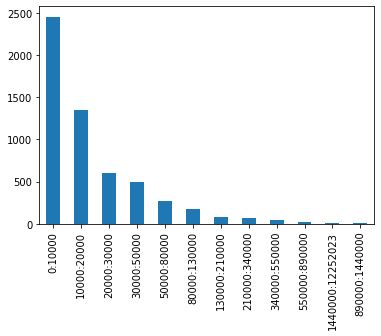

In [27]:
# Distribuição de cidades por faixa de população Estimada
ibge_municipio_populacao_estimada['faixaPopulacaoEstimada'].value_counts().plot(kind='bar')

In [28]:
# Usando as top 10% cidades mais violentas e menos violentas para criar um conjunto de dados rótulado (municipios_ranking),
# que discrimina se uma cidade é violenta ou não.

cols_selection = [
    'uf',
    'nomeMunicipio',
    'populacaoEstimada',
    # 'pib1000',
    'pibPerCapita',
    'atividadeMaisRelevanteValorBruto1', 
    'atividadeMaisRelevanteValorBruto2',
    'atividadeMaisRelevanteValorBruto3',
    'total_funcionarios',
    'part_homicidios_sem_ocupacao',
    'part_homicidios_com_ocupacao',
    'part_funcionarios_populacao1k',
    'part_homicidios_populacao1k',
]

faixa_populacao = '0:10000'

municipio_features_slice = (
    municipio_features[
        (municipio_features['faixaPopulacaoEstimada'] == faixa_populacao)
        & (municipio_features['uf'].isin(UFS))
    ][cols_selection]
)

rank_size = int(len(municipio_features_slice) * 0.1)

rank_col = 'part_homicidios_populacao1k'

target_col = 'violento'

top_municipios_mais_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size
)

top_municipios_menos_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size,
    ascending=True
)

top_municipios_mais_violentos[target_col] = True
top_municipios_menos_violentos[target_col] = False

municipios_ranking = pd.concat(
    [top_municipios_mais_violentos, top_municipios_menos_violentos],
    axis=0
)

display('top_municipios_mais_violentos', top_municipios_mais_violentos.head(5))
display('top_municipios_menos_violentos', top_municipios_menos_violentos.head(5))

'top_municipios_mais_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,violento
751,RN,São Bento do Norte,2747.000,69005.000,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,1.000,0.000,194.394,1.820,True
1418,BA,Barro Preto,5591.000,9643.000,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,1.000,0.000,86.210,1.431,True
1736,BA,São José da Vitória,5657.000,8119.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,0.833,0.167,82.729,1.061,True
693,RN,Lagoa d'Anta,6769.000,7435.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,297.000,0.714,0.286,43.876,1.034,True
1283,AL,Roteiro,6664.000,21798.000,"Agricultura, inclusive apoio à agricultura e a...","Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",643.000,0.667,0.333,96.489,0.900,True


'top_municipios_menos_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,total_funcionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,violento
1150,PE,Sairé,9932.000,14360.000,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,583.000,0.000,1.000,58.699,0.101,False
1425,BA,Bom Jesus da Serra,9880.000,5156.000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",415.000,0.000,1.000,42.004,0.101,False
892,PB,Juru,9867.000,7500.000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",429.000,1.000,0.000,43.478,0.101,False
310,PI,Ilha Grande,9426.000,7364.000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",442.000,0.000,1.000,46.892,0.106,False
32,MA,Boa Vista do Gurupi,9287.000,6611.000,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,395.000,1.000,0.000,42.533,0.108,False


top_municipios_mais_violentos kpis:
	avg 6057.745762711865
	CI (5495.932627118644, 6611.715677966102)
top_municipios_menos_violentos kpis:
	avg 7892.983050847458
	CI (7624.30720338983, 8149.56186440678)
KS-test KstestResult(statistic=0.4745762711864407, pvalue=2.2193961234991357e-06)


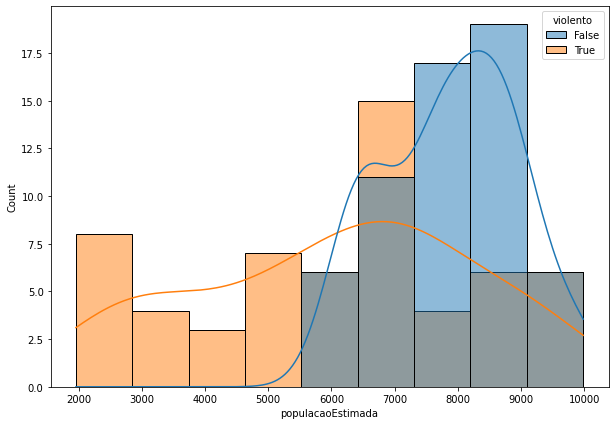

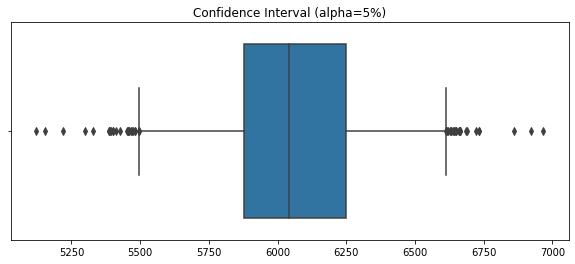

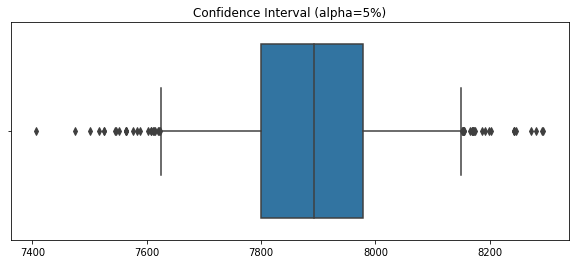

In [29]:
explainable_col = 'populacaoEstimada'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Considerando faixa populacional selecionada, existe diferença na população entre cidades mais/menos violentas
- As ciades mais violentas tem menor número de pessoas em relação

top_municipios_mais_violentos kpis:
	avg 0.5153628275156988
	CI (0.44694896839888143, 0.5910287991580234)
top_municipios_menos_violentos kpis:
	avg 0.12897705576948115
	CI (0.12472415364433752, 0.1336221624848189)
KS-test KstestResult(statistic=1.0, pvalue=8.211293089808295e-35)


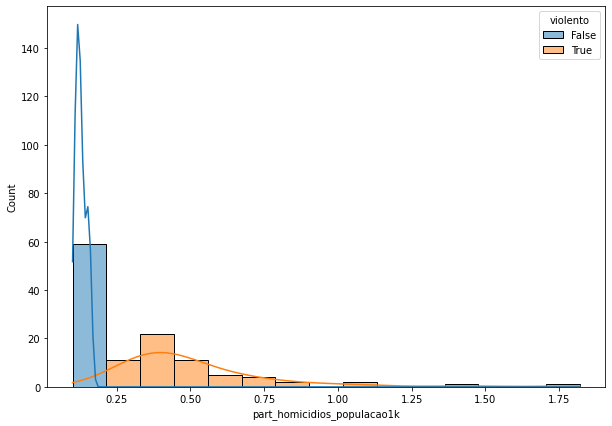

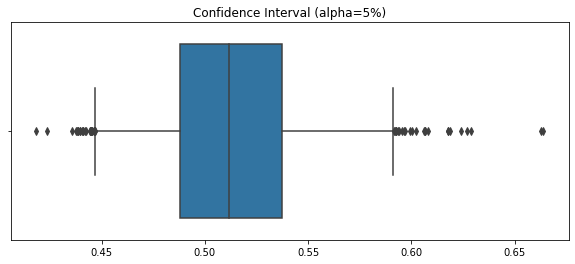

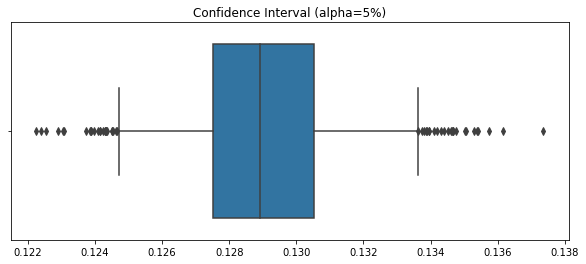

In [30]:
explainable_col = 'part_homicidios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença na taxa de homicídios entre cidades mais/menos violentas
- Em algumas cidades mais violentas, a quantidade de homicídios chega a 2 para cada mil habitantes
- Em relação as cidades menos violentas, a quantidade de homicídios é quase zero

top_municipios_mais_violentos kpis:
	avg 0.49967715899919285
	CI (0.3994975786924939, 0.6082647296206618)
top_municipios_menos_violentos kpis:
	avg 0.4915254237288136
	CI (0.3728813559322034, 0.6101694915254238)
KS-test KstestResult(statistic=0.22033898305084745, pvalue=0.1141436599629735)


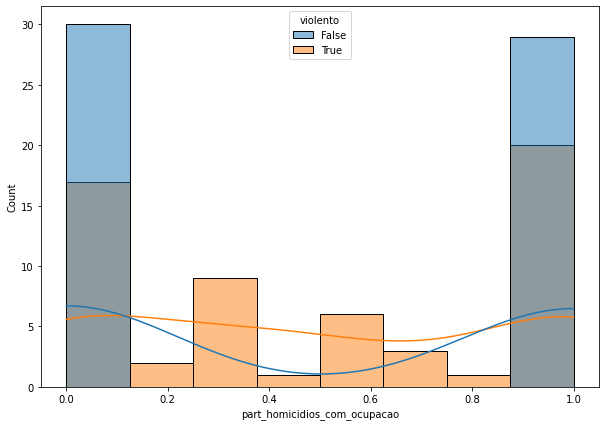

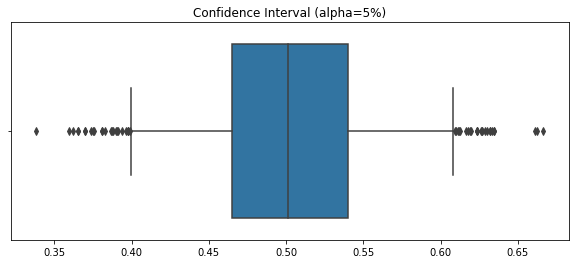

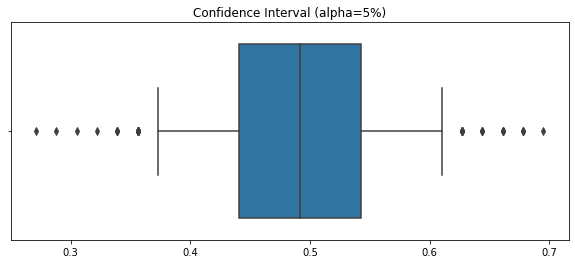

In [31]:
explainable_col = 'part_homicidios_com_ocupacao'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Não existe diferença de taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas

top_municipios_mais_violentos kpis:
	avg 74.09473229342863
	CI (64.27326544569777, 85.15813379419477)
top_municipios_menos_violentos kpis:
	avg 54.269704684218794
	CI (46.97642465014934, 63.063591639696966)
KS-test KstestResult(statistic=0.3898305084745763, pvalue=0.0002175281422142784)


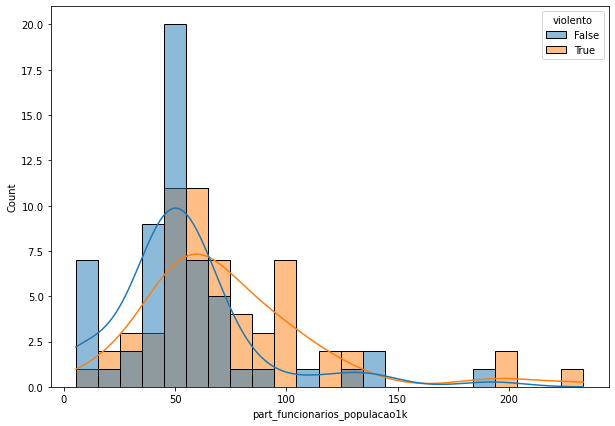

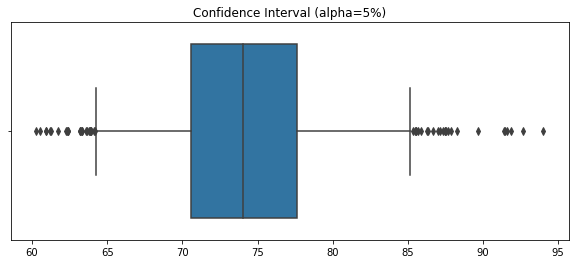

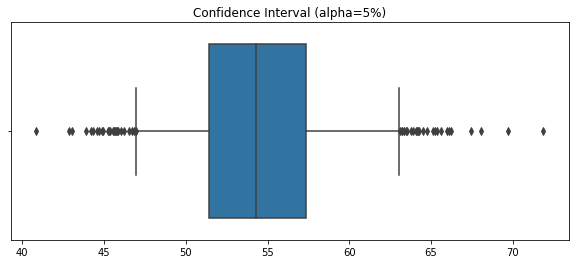

In [32]:
explainable_col = 'part_funcionarios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença de empregabilidade entre cidades violentas e não violentas
- A empregabilidade em cidades mais violentas é maior (média de 74)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- A empregabilidade em cidades menos violentas é menor (média de 54)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

top_municipios_mais_violentos kpis:
	avg 12364.152542372882
	CI (9912.046610169491, 15447.899152542372)
top_municipios_menos_violentos kpis:
	avg 11245.152542372882
	CI (8479.91059322034, 15453.092796610168)
KS-test KstestResult(statistic=0.2542372881355932, pvalue=0.04374463218775545)


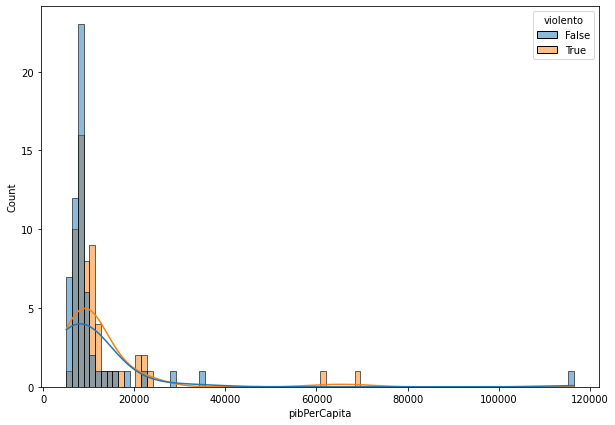

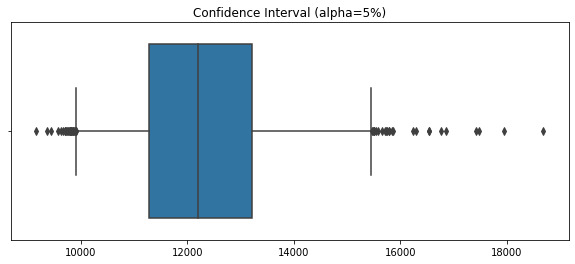

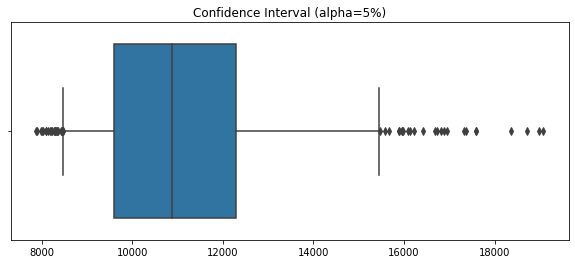

In [33]:
explainable_col = 'pibPerCapita'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe uma pequena diferença significante de PIB entre cidades mais/menos violentas
- O PIB em cidades mais violentas é maior (média de 12364)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- O PIB em cidades menos violentas é menor (média de 11245)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

## Relação entre características e a variável alvo (cidade violenta?)

In [34]:
ppscores = mg.get_ppscore_matrix(municipios_ranking)

feature_relevante = mg.get_ppscore_feature_relevante(ppscores, target_variable=target_col, cols=cols_selection)

display(feature_relevante)

,x,ppscore,is_valid_score,metric
155,part_homicidios_populacao1k,1.000,True,weighted F1
38,populacaoEstimada,0.316,True,weighted F1
116,part_homicidios_sem_ocupacao,0.263,True,weighted F1
129,part_homicidios_com_ocupacao,0.263,True,weighted F1
142,part_funcionarios_populacao1k,0.183,True,weighted F1
12,uf,0.182,True,weighted F1
90,atividadeMaisRelevanteValorBruto3,0.173,True,weighted F1
51,pibPerCapita,0.061,True,weighted F1
25,nomeMunicipio,0.000,True,None
64,atividadeMaisRelevanteValorBruto1,0.000,True,weighted F1


<AxesSubplot:title={'center':'PPS matrix (%)'}, xlabel='feature', ylabel='target'>

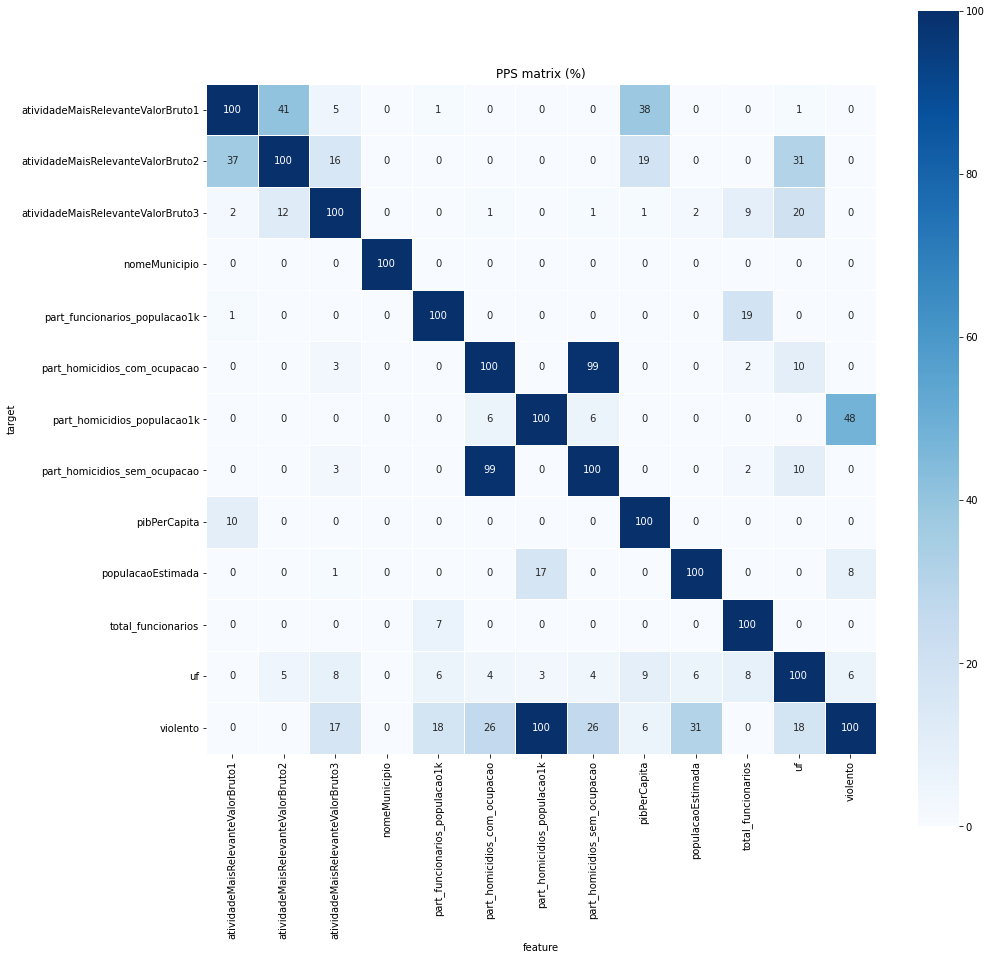

In [35]:
mg.plot_ppscore_heatmap(ppscores, figsize=(15,15))

# Conclusion

- A relação entre cidades mais violentas com alta taxa de empregabilidade e nível menor de população parece ser contra-intuitivo 
- Em cidades mais violentas, as pessoas tendem a ser conhecer mais devido ao número menor da população
- Em cidades mais violentas, a população tem maior empregabilidade e, provavelmenente, mais poder de compra. Isso provavelmente chama a atenção de aproveitadores/bandidos, e, consequentemente, causar mais homicídios.
- Precisamos investigar se as atividades econômicas de uma cidade influencia a violência (taxa de homicídios)
- Outras análises também precisam ser feitas para cidades com outras faixas de população estimada